In [2]:
import numpy as np
import pandas as pd
from plotnine import *
import warnings
from math import ceil, floor
from random import choices
import statsmodels.api as sm

In [3]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

## Data Cleaning/Restructuring

#### SDE Feeders data Import and Process

In [4]:
feeders = pd.read_csv('Data/Feeder_Metrics.csv')

In [5]:
feeders.head()

,SOURCE_IND,STATE_NAME,COMPANY_NAME,BRKR_DISTRICT_CODE,BRKR_DISTRICT_NAME,BRKR_TAX_DIST_CODE,BRKR_TAX_DIST_NAME,SUBSTATION_ID,SUBSTATION_NAME,SUB_NUMBER,MASTER_CDF,FEEDER_NUMBER,OPERATING_VOLTAGE,EFFECTIVE_KV_CLASS,CIRCUIT_USE,CONSTRUCTION_CLASS,TOT_CKT_LNGTH_FT,TOT_CKT_LNGTH_MI,TOT_OH_LNGTH_FT,TOT_OH_LNGTH_MI,TOT_UG_LNGTH_FT,TOT_UG_LNGTH_MI,TOT_3PHS_LNGTH_FT,TOT_3PHS_OH_LNGTH_FT,TOT_3PHE_UG_LNGTH_FT,TOT_5KV_LNGTH_FT,TOT_5KV_OH_3PHS_LNGTH_FT,TOT_5KV_OH_LNGTH,TOT_5KV_OH_OT_LNGTH_FT,TOT_5KV_UG_3PHS_LNGTH_FT,TOT_5KV_UG_OT_LNGTH_FT,TOT_15KV_LNGTH_FT,TOT_15KV_OH_3_PHS_LNGTH_FT,TOT_15KV_OH_LNGTH_FT,TOT_15KV_OH_OT_LNGTH_FT,TOT_15KV_UG_3PHS_LNGTH_FT,TOT_15KV_UG_OT_LNGTH_FT,TOT_OVR15KV_LNGTH_FT,TOT_OVR15KV_OH_3PHS_LNGTH_FT,TOT_OVR15KV_OH_LNGTH,TOT_OVR15KV_OH_OT_LNGTH_FT,TOT_OVR15KV_UG_3PHS_LNGTH_FT,TOT_OVR15KV_UG_OT_LNGTH_FT,CUSTOMERS_SERVED,BREAKER_SETTING,TRA_NOM_CA,SUB_NOM_VOLTGE,SUB_TAX_DIST,EAP_SUB_ID,SUB_STR_ADDRESS,STA_CONFIG,STA_REGLTN,SUB_LONG,SUB_LAT,SUB_GPS_DATE,TBL_LOAD_DATE
0,NE,Massachusetts,Massachusetts Electric,5.0,Southeast,268.0,Somerset,13581404,RIVERSIDE SUB,17,05_05_17J1,17J1,4.16,5000.0,Distribution,OH,22145.0,4.19,22081.0,4.18,64.0,0.01,9193.0,9129.0,64.0,22145.0,9129.0,22081.0,12952.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,723.0,NaN,0.0,0.0,268.0,NaN,"1981 RIVERSIDE AVE, SOMERSET, MA",NaN,NaN,-71.145782,41.739189,NaN,2019-07-23 04:16:29
1,NE,Massachusetts,Massachusetts Electric,5.0,Southeast,268.0,Somerset,13581404,RIVERSIDE SUB,17,05_05_17J3,17J3,4.16,5000.0,Distribution,OH,33148.0,6.28,32360.0,6.13,788.0,0.15,13408.0,12620.0,788.0,33148.0,12620.0,32360.0,19740.0,788.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,NaN,0.0,0.0,268.0,NaN,"1981 RIVERSIDE AVE, SOMERSET, MA",NaN,NaN,-71.145782,41.739189,NaN,2019-07-23 04:16:29
2,NE,Massachusetts,Massachusetts Electric,5.0,Southeast,262.0,Fall River,13581416,HATHAWAY ST. SUB,106,05_05_106W42,106W42,13.80,15000.0,Distribution,Mixed,51594.0,9.77,23331.0,4.42,28263.0,5.35,38600.0,13682.0,24918.0,0.0,0.0,0.0,0.0,0.0,0.0,51594.0,13682.0,23331.0,9649.0,24918.0,3345.0,0.0,0.0,0.0,0.0,0.0,0.0,2469.0,NaN,0.0,0.0,262.0,05-0106,"1 HATHAWAY ST, FALL RIVER, MA",NaN,NaN,-71.156387,41.716793,NaN,2019-07-23 04:16:29
3,NE,Massachusetts,Massachusetts Electric,5.0,Southeast,262.0,Fall River,13581416,HATHAWAY ST. SUB,106,05_05_106W43,106W43,13.80,15000.0,Distribution,Mixed,46154.0,8.74,9311.0,1.76,36843.0,6.98,40301.0,4998.0,35303.0,0.0,0.0,0.0,0.0,0.0,0.0,45957.0,4998.0,9114.0,4116.0,35303.0,1540.0,0.0,0.0,0.0,0.0,0.0,0.0,2257.0,NaN,0.0,0.0,262.0,05-0106,"1 HATHAWAY ST, FALL RIVER, MA",NaN,NaN,-71.156387,41.716793,NaN,2019-07-23 04:16:29
4,NE,Massachusetts,Massachusetts Electric,5.0,Southeast,262.0,Fall River,13581416,HATHAWAY ST. SUB,106,05_05_106W44,106W44,13.80,15000.0,Distribution,Mixed,76851.0,14.56,53545.0,10.14,23306.0,4.41,51580.0,31474.0,20106.0,1338.0,754.0,1338.0,584.0,0.0,0.0,74998.0,30313.0,51692.0,21379.0,20106.0,3200.0,0.0,0.0,0.0,0.0,0.0,0.0,5190.0,NaN,0.0,0.0,262.0,05-0106,"1 HATHAWAY ST, FALL RIVER, MA",NaN,NaN,-71.156387,41.716793,NaN,2019-07-23 04:16:29


In [6]:
# lowercase columns
feeders.columns = [x.lower() for x in feeders.columns]

# Select only MA legacy companies
MA_feeders = feeders.loc[feeders['company_name'].isin(['Massachusetts Electric', 'Nantucket'])].reset_index(drop=True)
MA_feeders.to_csv('MA_Feeders.csv')

# Subsitute Nantucket for nulls in some columns
ma = pd.read_csv('MA_Feeders.csv', index_col=0)
ma.loc[ma['brkr_district_name'].isna(), 'brkr_district_name'] = 'Nantucket'
ma.loc[ma['brkr_district_name'].isna(), 'brkr_district_code'] = 4.0

# Assign Column Types
cat_cols = ['master_cdf', 'source_ind', 'state_name', 'company_name', 'circuit_use', 'construction_class', 'brkr_district_name', 'brkr_tax_dist_code', 'sub_tax_dist']
avg_cols = ['operating_voltage', 'effective_kv_class', 'sub_nom_voltge']
sum_cols = [x for x in ma.columns if x.startswith('tot_')] + ['customers_served']

# Aggregation Dictionary
agg_dict = {**{x: ['mean'] for x in avg_cols}, **{x: ['sum'] for x in sum_cols}} # 'max', 'min' for avg_cols, 'count' for sum_cols

# Select only cat/avg/sum columns
ma = ma[cat_cols + avg_cols + sum_cols]

# Group by categorical columns and aggregate
mafeeders = ma.groupby(cat_cols).agg(agg_dict).reset_index()
mafeeders.columns = mafeeders.columns.get_level_values(0)

# Convert to string types
mafeeders['brkr_tax_dist_code'] = mafeeders['brkr_tax_dist_code'].astype('str') 
mafeeders['sub_tax_dist'] = mafeeders['sub_tax_dist'].astype('str')

# Rename some columns
mafeeders.rename(columns={'master_cdf': 'cdf', 'brkr_district_name': 'district'}, inplace=True)

In [7]:
mafeeders.head()

,cdf,source_ind,state_name,company_name,circuit_use,construction_class,district,brkr_tax_dist_code,sub_tax_dist,operating_voltage,effective_kv_class,sub_nom_voltge,tot_ckt_lngth_ft,tot_ckt_lngth_mi,tot_oh_lngth_ft,tot_oh_lngth_mi,tot_ug_lngth_ft,tot_ug_lngth_mi,tot_3phs_lngth_ft,tot_3phs_oh_lngth_ft,tot_3phe_ug_lngth_ft,tot_5kv_lngth_ft,tot_5kv_oh_3phs_lngth_ft,tot_5kv_oh_lngth,tot_5kv_oh_ot_lngth_ft,tot_5kv_ug_3phs_lngth_ft,tot_5kv_ug_ot_lngth_ft,tot_15kv_lngth_ft,tot_15kv_oh_3_phs_lngth_ft,tot_15kv_oh_lngth_ft,tot_15kv_oh_ot_lngth_ft,tot_15kv_ug_3phs_lngth_ft,tot_15kv_ug_ot_lngth_ft,tot_ovr15kv_lngth_ft,tot_ovr15kv_oh_3phs_lngth_ft,tot_ovr15kv_oh_lngth,tot_ovr15kv_oh_ot_lngth_ft,tot_ovr15kv_ug_3phs_lngth_ft,tot_ovr15kv_ug_ot_lngth_ft,customers_served
0,04_04_101L1,NE,Massachusetts,Nantucket,Distribution,UG,Nantucket,200.0,200.0,13.2,15000.0,0.0,2117.0,0.40,0.0,0.00,2117.0,0.40,1932.0,0.0,1932.0,0.0,0.0,0.0,0.0,0.0,0.0,2117.0,0.0,0.0,0.0,1932.0,185.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0
1,04_04_101L2,NE,Massachusetts,Nantucket,Distribution,Mixed,Nantucket,200.0,200.0,13.2,15000.0,0.0,454229.0,86.03,117368.0,22.23,336861.0,63.80,104344.0,87213.0,17131.0,0.0,0.0,0.0,0.0,0.0,0.0,454229.0,87213.0,117368.0,30155.0,17131.0,319170.0,0.0,0.0,0.0,0.0,0.0,0.0,2681.0
2,04_04_101L3,NE,Massachusetts,Nantucket,Distribution,Mixed,Nantucket,200.0,200.0,13.2,15000.0,0.0,69300.0,13.12,30559.0,5.79,38741.0,7.34,21152.0,13369.0,7783.0,0.0,0.0,0.0,0.0,0.0,0.0,69300.0,13369.0,30559.0,17190.0,7783.0,30958.0,0.0,0.0,0.0,0.0,0.0,0.0,1445.0
3,04_04_101L4,NE,Massachusetts,Nantucket,Distribution,Mixed,Nantucket,200.0,200.0,13.2,15000.0,0.0,131496.0,24.90,56477.0,10.70,75019.0,14.21,36464.0,27744.0,8720.0,0.0,0.0,0.0,0.0,0.0,0.0,131496.0,27744.0,56477.0,28733.0,8720.0,66299.0,0.0,0.0,0.0,0.0,0.0,0.0,2851.0
4,04_04_101L5,NE,Massachusetts,Nantucket,Distribution,Mixed,Nantucket,200.0,200.0,13.2,15000.0,0.0,168938.0,32.00,43227.0,8.19,125711.0,23.81,35907.0,28160.0,7747.0,0.0,0.0,0.0,0.0,0.0,0.0,168938.0,28160.0,43227.0,15067.0,7747.0,117964.0,0.0,0.0,0.0,0.0,0.0,0.0,1669.0


### Historical Data Import and Process

In [8]:
# Historical Data Cleaning Function
def clean_years_after(row):
    if row['years_until'] == 1:
        row['Y2_After'] = np.nan
        row['Y3_After'] = np.nan
        row['Y4_After'] = np.nan
    elif row['years_until'] == 2:
        row['Y3_After'] = np.nan
        row['Y4_After'] = np.nan
    elif row['years_until'] == 3:
        row['Y4_After'] = np.nan
    return row

In [9]:
# Processing function
def process_cycle_prune_df(data, value_name):
    ci_prune = data.copy()
    ci_prune = ci_prune[['Feeder ID', 'Fiscal Year', 'Y1_After', 'Y2_After', 'Y3_After', 'Y4_After',\
                        'years_since', 'years_until']]
    ci_prune.rename(columns={'Feeder ID': 'cdf', 'Fiscal Year': 'project_year'}, inplace=True)
    ci_prune = ci_prune.apply(clean_years_after, axis=1)
    ci = ci_prune.melt(id_vars=['cdf', 'project_year', 'years_since', 'years_until'],
                            var_name = 'years_after', value_name = value_name)
    ci.drop(labels=['years_since'], axis=1, inplace=True)
    ci.rename(columns={'years_until': 'cycle_length'}, inplace=True)
    ci['years_after'] = ci['years_after'].apply(lambda x: int(x.replace('Y', '').replace('_After', '')))
    ci['years_after'] = ci['years_after']
    ci['year'] = ci['project_year'] + ci['years_after'] - 1
    ci = ci.loc[(ci['year'] <= (ci['project_year'] + ci['cycle_length'])) | \
                        (ci['cycle_length'].isna())].sort_values(by=['cdf', 'project_year', 'year'], ascending=[True, True, True])\
                .reset_index(drop=True)
    ci.loc[(ci['project_year']>=2015) & (ci['cycle_length'].isna()), 'cycle_length'] = 5
    return ci

In [10]:
# Import and process
ci_prune = pd.read_csv('data/cycle_prune_ci_next.csv')
cmi_prune = pd.read_csv('data/cycle_prune_cmi_next.csv')
outages_prune = pd.read_csv('data/cycle_prune_events_next.csv')

ci = process_cycle_prune_df(data = ci_prune, value_name='ci')
cmi = process_cycle_prune_df(data = cmi_prune, value_name='cmi')
outages = process_cycle_prune_df(data = outages_prune, value_name='outages')

ci = ci.loc[~ci['ci'].isna()]
cmi = cmi.loc[~cmi['cmi'].isna()]
outages = outages.loc[~outages['outages'].isna()]

In [13]:
# Join outages, ci and cmi data
mahist = pd.merge(ci, outages, on=['cdf', 'project_year', 'cycle_length', 'years_after', 'year'], how='outer')
mahist = pd.merge(mahist, cmi, on=['cdf', 'project_year', 'cycle_length', 'years_after', 'year'], how='outer')
mahist = mahist[['cdf', 'project_year', 'cycle_length', 'years_after', 'year', 'outages', 'ci', 'cmi']]

# filtering out storm-related outliers
# mahist = mahist.loc[mahist['cmi']<1000000] 
mahist = mahist.loc[mahist['year']>2011] 

In [15]:
# Average cdf data over years after prune
feederhist = mahist.groupby(['cdf', 'years_after'])[['outages', 'ci', 'cmi']].agg(['mean']).reset_index().round()
feederhist.columns = ['_'.join(col).rstrip('_') for col in feederhist.columns.values]
# feederhist.rename(columns={'outages_max': 'outages_mean', 'ci_max': 'ci_mean', 'cmi_max': 'cmi_mean'}, inplace=True)

#### NE pruning schedule data and SDE NE feeders - wish to obtain MA-only pruning schedule data

In [17]:
# Import NE pruning schedules by cdf
sched = pd.read_csv('data/NE - Cycle Prune Schedule.csv')
sched.columns = [x.lower() for x in sched.columns]

In [19]:
# Select only MA areas and rename some columns
feeders = feeders.rename(columns={'master_cdf': 'cdf', 'brkr_district_name': 'district'})
feeders_small = feeders.loc[(feeders['state_name']=='Massachusetts') & (feeders['district']!='Nantucket')]\
                [['cdf', 'state_name', 'customers_served']].drop_duplicates(subset=['cdf'])

### Prepare Schedule/Feeder data to have full Feeder Pruning Schedule

In [21]:
# Join future scheduling data with feeders data
sched_feeders = pd.merge(sched, feeders_small, on='cdf', how='left')

In [24]:
# Select only MA feeders
masched = sched_feeders.loc[sched_feeders['cdf'].str.startswith('05')]
masched = masched.loc[~masched['state_name'].isna()]
masched = masched[['cdf', 'fy last', 'fy next']]

# correcting feeders w/ missing 'fy last' - assuming 5 year pruning cycle
masched.loc[(masched['fy last'].isna()) & (masched['fy next']==2020), 'fy last'] = 2015
masched.loc[(masched['fy last'].isna()) & (masched['fy next']==2021), 'fy last'] = 2016
masched.loc[(masched['fy last'].isna()) & (masched['fy next']==2022), 'fy last'] = 2017
masched.loc[(masched['fy last']=='Unknown') & (masched['fy next']==2020), 'fy last'] = 2015
masched.loc[(masched['fy last']=='Unknown') & (masched['fy next']==2021), 'fy last'] = 2016

masched['fy last'] = masched['fy last'].astype('int')

# # make 'years after' match convention in cycle pruning history
# masched['years_after'] = 2020 - masched['fy last'] + 1

# Join length of oh wire/customers served/district data to feeder schedule
masched = pd.merge(masched, mafeeders[['cdf', 'district', 'tot_oh_lngth_mi', 'customers_served']], on='cdf', how='left')

In [26]:
# Combine cycle pruning history data and SDE MA feeders data to add total oh miles & customers served 
mahist = pd.merge(mahist, mafeeders[['cdf', 'tot_oh_lngth_mi', 'customers_served']], on='cdf', how='left')

In [28]:
# Fill oh wire length NULLs with mean
mahist['tot_oh_lngth_mi'] = mahist['tot_oh_lngth_mi'].fillna(value=mahist['tot_oh_lngth_mi'].mean())

# Set any length smaller than .1 to .1
mahist.loc[mahist['tot_oh_lngth_mi']<0.1, 'tot_oh_lngth_mi'] = 0.1

In [29]:
# # Calculate the improvement in ci and cmi due to pruning (using years 1 & 2 after pruning only)
# prunerel = feederhist.pivot(index='cdf', columns='years_after').reset_index()
# prunerel.columns = [(x[0] + '_' + str(x[1])).rstrip('_') for x in prunerel.columns.values]

# prunerel['pruning_effect_ci'] = prunerel['ci_mean_1'] - prunerel['ci_mean_2']
# prunerel['pruning_effect_cmi'] = prunerel['cmi_mean_1'] - prunerel['cmi_mean_2']
# prunerel = prunerel[['cdf', 'pruning_effect_ci', 'pruning_effect_cmi']]

# Calculate traditional feeder reliability using historical outages
mareliability = mahist.groupby('cdf')[['outages', 'ci', 'cmi']].sum().reset_index()\
                .rename(columns={'outages': 'outages_rel', 'ci': 'ci_rel', 'cmi': 'cmi_rel'})

# # Combine pruning and outage reliability data
# mareliability = pd.merge(mareliability, prunerel, on='cdf', how='left')

# Combine the schedule data with reliability data
masched = pd.merge(masched, mareliability, on='cdf', how='left')

masched['year'] = 2020

In [33]:
# Sum historical data by years after pruning
yearlyhist = mahist.groupby('years_after')[['outages', 'tot_oh_lngth_mi']].sum().reset_index()

# Create 'Outages per Mile' metric
yearlyhist['opm'] = yearlyhist['outages']/yearlyhist['tot_oh_lngth_mi']

In [35]:
masched.loc[masched['fy next']==2020]['tot_oh_lngth_mi'].sum()

2654.93

In [38]:
# Calculate max of historic outages/ci/cmi *.8
feederhistmax = feederhist.groupby('cdf')[['outages_mean', 'ci_mean', 'cmi_mean']].max()*.8
feederhistmax.reset_index(inplace=True)

In [40]:
# Add rows of forecasted feeder outages for additional 10 years
for i in range(5, 15):
    fhm = feederhistmax.copy()
    fhm['years_after'] = i
    fhm[['cdf', 'years_after', 'outages_mean', 'ci_mean', 'cmi_mean']]
    feederhist = pd.concat([feederhist, fhm], axis=0)

In [42]:
feederhist = feederhist.sort_values(['cdf', 'years_after'])

# Computing outages for feeders not in pruning schedule

In [44]:
# Import outage data for feeders not in pruning schedule
mafeeders2 = pd.read_csv('data/outages_ma_cdf.csv')

In [46]:
# Rename a few columns
mafeeders2.rename(columns={'Reportable Cust. Inter.': 'ci', 'Reportable Cust. Min. Inter.': 'cmi', 
                           'AFCTD_FDR_LIST': 'cdf'}, inplace=True)

In [47]:
# Select only events with duration over 5 minutes, is regulatory reportable, and has 'tree' as the cause group
mafeeders3 = mafeeders2.loc[(mafeeders2['Event Duration']>5) & (mafeeders2['Regulatory Reportable Event']=='Y') & \
                           (mafeeders2['Cause Group']=='Tree')]\
            [['cdf', 'year', 'ci', 'cmi']]

In [48]:
# Double checking that there is no overlap? (Between scheduled/unscheduled feeders)
nosched = pd.merge(masched, mafeeders3, on='cdf', how='right')
nosched = nosched.loc[nosched['year_x'].isna()][['cdf', 'year_y', 'ci', 'cmi']].rename(columns={'year_y': 'year'})

## Get average number of customers served

In [50]:
# Import customers served data
cs = pd.read_csv('MECO_custs_svd_sent.csv')

In [51]:
cs.head()

,Unnamed: 0,DISTRCT_CD,DISTRCT_NAME,YR,FDR_MECO,NO_CUSTS_SVD
0,0,1,Central,2003,05_01_10J323,611.666667
1,1,1,Central,2003,05_01_10J366,1060.000000
2,2,1,Central,2003,05_01_10J383,851.333333
3,3,1,Central,2003,05_01_10J99,0.000000
4,4,1,Central,2003,05_01_11J314,406.750000


In [52]:
cs = cs.rename(columns = {'FDR_MECO':'cdf', 'YR':'year', 'NO_CUSTS_SVD':'customers_served'}).drop('Unnamed: 0', axis=1)

In [53]:
# Select customers served counts from most recent feeder data
most_recent = cs.groupby('cdf')['year'].max().reset_index()

# Was blocked out?
cs = pd.merge(cs, most_recent, on=['cdf', 'year'], how='inner')
cs = cs.loc[cs['customers_served']>0][['cdf', 'year', 'customers_served']].rename(columns={'year': 'data_year'})

In [54]:
# Join new customer counts to scheduled pruning data
masched = pd.merge(masched.drop(labels=['customers_served'], axis=1), cs, on='cdf', how='right')

In [55]:
masched['customers_served'].sum()

1382264.2597041847

In [56]:
masched = masched.loc[~masched['year'].isna()]

## Get non-tree-related ci/cmi

In [57]:
mafeeders4 = mafeeders2.loc[(mafeeders2['Event Duration']>5) & (mafeeders2['Regulatory Reportable Event']=='Y') & \
                           (mafeeders2['Cause Group']!='Tree')]\
            [['cdf', 'year', 'ci', 'cmi']]

In [58]:
mafeeders4.groupby('year')[['ci', 'cmi']].sum().mean()

ci     8.971518e+05
cmi    1.683037e+08
dtype: float64

## Fill in ci/cmi for feeders with no history when they're in year 5+ after pruning

In [59]:
def cmiPolynomial(x):
    # Yearly regression polynomial for cmi as a function of outages
    return 96.672*x**2 - 410.189*x + 632.069

In [60]:
def ciPolynomial(x):
    # Yearly regression polynomial for ci as a function of outages
    return 0.3996*x**2 - 1.2707*x + 2.4573

In [61]:
TD = pd.Series([31734916, 35426733, 31197821])
TD.mean()

32786490.0

In [62]:
def penalty_calc(penalty='SAIFI', year=2020, observed_value=None):
    """
    penalty (str): Penalty calculation, either 'SAIFI' or 'SAIDI'
    year (int): Penalty calculation year (fiscal year)
    observed_value (int): Expected SAIDI or SAIFI value for the year
    """
    if penalty=='SAIFI':
        deadband_dict = {2020: [1.4, 1.58], 2021: [1.4, 1.58], 2022: [1.37, 1.55],
                         2023: [1.37, 1.55], 2024: [1.37, 1.55], 2025: [1.34, 1.52]}
    else:
        deadband_dict = {2020: [147, 187], 2021: [147, 187], 2022: [140, 180],
                         2023: [140, 180], 2024: [140, 180], 2025: [134, 174]}
    
    max_penalty = 8576431 #Note: this is the average Max Penalty value for years 2016 - 2018
    
    if observed_value < deadband_dict[year][0]:
        return 0
    elif observed_value > deadband_dict[year][1]:
        return 0.25*(((deadband_dict[year][1] - deadband_dict[year][0])/(deadband_dict[year][1] - deadband_dict[year][0]))**2)*max_penalty
    else:
        return 0.25*(((observed_value - deadband_dict[year][0])/(deadband_dict[year][1] - deadband_dict[year][0]))**2)*max_penalty

In [63]:
penalty_calc(penalty='SAIDI', year=2020, observed_value=155)

85764.31000000001

In [64]:
penalty_calc(penalty='SAIDI', year=2020, observed_value=165)

434181.819375

## Process labor costs

In [65]:
labor_costs = pd.read_csv('MECO_deferred_labor_costs_ag_EDIT.csv')

In [66]:
labor_costs.head(3)

,district,year,5,6,7,8,9
0,Central,2021,5692,6888,7912,8709,9336
1,Merrimack Valley,2021,6329,7658,8797,9683,10380
2,North Shore,2021,5336,6456,7417,8164,8751


In [67]:
# labor_costs = labor_costs.rename(columns = {'5 (base)': '5'})

In [68]:
# Reshape labor data
labor = pd.melt(frame=labor_costs, id_vars=['district', 'year'], var_name='years_after_prior', value_name='labor_cost_per_mi')

In [69]:
labor.head()

,district,year,years_after_prior,labor_cost_per_mi
0,Central,2021,5,5692
1,Merrimack Valley,2021,5,6329
2,North Shore,2021,5,5336
3,South Shore,2021,5,5760
4,Southeast,2021,5,6272


In [70]:
labor['years_after_prior'] = labor['years_after_prior'].astype('int')

### Prepare scheduled data for processing

In [71]:
masched.head()

,cdf,fy last,fy next,district,tot_oh_lngth_mi,outages_rel,ci_rel,cmi_rel,year,data_year,customers_served
0,05_01_0012,2018.0,2023.0,Central,2.44,0.0,0.0,0.0,2020.0,2019,1.000000
1,05_01_10J323,2018.0,2023.0,Central,0.96,3.0,717.0,63524.0,2020.0,2019,748.818182
2,05_01_10J366,2018.0,2023.0,Central,1.33,4.0,39.0,3483.0,2020.0,2019,1165.636364
3,05_01_10J383,2015.0,2021.0,Central,3.72,7.0,63.0,5836.0,2020.0,2019,893.181818
4,05_01_11J314,2018.0,2023.0,Central,0.74,12.0,463.0,95760.0,2020.0,2019,431.909091


In [72]:
# Calculate years after pruning
masched['years_after'] = masched['year'] - masched['fy last'] + 1

# Assume year 2020 for processing
masched.loc[masched['fy next']==2020, 'years_after'] = 1
masched.loc[masched['fy next']==2020, 'fy last'] = 2020
masched.loc[masched['fy next']==2020, 'fy next'] = 2025

In [73]:
yearmeans = mahist[['outages', 'ci', 'cmi']].mean()

In [74]:
yearmeans

outages        3.179541
ci           364.678149
cmi        58256.355428
dtype: float64

In [75]:
len(['years_after_prior', 'cmi_rel', 'ci_rel', 'outages_rel', 'customers_served']) * [False]

[False, False, False, False, False]

In [76]:
def possible_outcomes(year, df_dict, feeder_history_df, labor_cost_df, budget_strategy, budget, pruning_prioritization):
    """
    year (int): Fiscal year of prediction
    df_dict (dict): Key is a fiscal year, value is a pruning schedule with any/all deferments established. To make a prediction
                    on FY 2021, we use df_dict = madf_dict = {2020: masched.copy()}. Once possible_outcomes is run for 
                    FY 2021, df_dict is expanded and looks like: 
                    {2020: masched.copy(), 2021: madf_hyp}, where madf hyp is the pruning schedule df for 2021.
    feeder_history_df (df): Dataframe for feeder history 
    labor_cost_df (df): Dataframe containing year-by-year labor costs for feeders in each region
    budget_strategy (str): A budget in the form $10.M or $20M
    budget (float): The budget within which the Vegetation dept. has to work for the corresponding fiscal year
    pruning_prioritization (list): List of columns in the feeder_history_df that are used to prioritize feeders (descending)
    
    Outputs are a dataframe of outcomes and a dictionary with years as keys and values as pruning schedules. The outcomes
    dataframe contains the following columns: 'year', 'budget_strategy', 'budget', 'miles_pruned', 'miles_not_pruned'
    'cost_per_mi', 'total_cost', 'tree_ci', 'tree_cmi', 'saifi', 'saifi_penalty', 'saidi', 'saidi_penalty'. 
    
    You should feed the output dict of the 2021 run as the argument for df_dict into the 2022 run, if you want 2022's results
    to be dependent on what happened in 2021. 
    
    # df_dict = madf_dict = {2020: masched.copy()}
    """
    
    # Results of Stela's Hazard Tree Forecast Model 
    tree_med_dict = {2020: 414, 2021: 414, 2022: 445, 2023: 445, 2024: 614, 2025: 614} # Trees down due to infestations by year
    
    # Create empty dataframe for outage data?
    outcomes = pd.DataFrame()
    
    # Return values of previous year's df_dict key?
    madf = df_dict[year-1] #'year' starts at 2021, which would go to 2020
    
    if 'labor_cost' in madf.columns: # Doesn't initially have it?
        madf = madf.drop(labels=['labor_cost_per_mi', 'labor_cost',], axis=1)
    madf['year'] = year
    madf['years_after_prior'] = madf['years_after']
    madf['years_after'] = madf['years_after_prior'] + 1

    # Get the feeders that are candidates for being pruned. These are the feeders whose scheduled next
    # pruning year corresponds to 'year'. With these feeders, arrange them by highest priority to 
    # lowest priority, and get running totals of the overhead miles and labor costs.
    
    # Select scheduled year for pruning candidates
    prune_candidates = madf.loc[(madf['fy next']==year)]\
                        .sort_values(by=pruning_prioritization, 
                                     ascending=[False]*len(pruning_prioritization))
    # Join 'prune candidate's and 'labor cost' dataframes
    prune_candidates = pd.merge(prune_candidates, labor_cost_df, 
                              on=['district', 'year', 'years_after_prior'], how='left')
    # Calculate per feeder labor costs as 'cost per mi' * 'total miles of overhead feeder length'
    prune_candidates['labor_cost'] = prune_candidates['labor_cost_per_mi']*prune_candidates['tot_oh_lngth_mi']
    # Create column with cumulative sum of labor costs
    prune_candidates['cumsum_labor_cost'] = prune_candidates['labor_cost'].cumsum()
    # Create column with cumulative overhead feeder length
    prune_candidates['cumsum_oh_mi'] = prune_candidates['tot_oh_lngth_mi'].cumsum()

    # Determine which feeders get pruned and which get deferred based on budget
    if budget=='unlimited':
        pruned_feeders = prune_candidates.loc[prune_candidates['cumsum_labor_cost']<=50000000]
        unpruned_feeders = prune_candidates.loc[prune_candidates['cumsum_labor_cost']>50000000]
        total_cost = pruned_feeders['labor_cost'].sum()
    else:
        # Select pruning candidates were cumulative costs are below budget
        pruned_feeders = prune_candidates.loc[prune_candidates['cumsum_labor_cost']<=budget]
        # Note feeders that went unpruned
        unpruned_feeders = prune_candidates.loc[prune_candidates['cumsum_labor_cost']>budget]
        # ???
        total_cost = 5*budget
    
    # Alter the 'fy next' numbers for the feeders that were prune candidates. Those that get
    # pruned have 5 years added to the year and those that get deferred get 1 year added, 
    # resulting in them appearing on the following years' schedule.
    pruned_feeders['fy next'] = year + 5
    pruned_feeders['fy last'] = year
    pruned_feeders['years_after'] = 1
    pruned_miles = pruned_feeders['tot_oh_lngth_mi'].sum()

    # Track unpruned feeders with new dataframe
    unpruned_feeders = prune_candidates.loc[prune_candidates['cumsum_labor_cost']>budget]
    # Add one year to planned pruning schedule
    unpruned_feeders['fy next'] = year + 1
    # Calculate non-pruned miles
    unpruned_miles = prune_candidates['tot_oh_lngth_mi'].sum() - pruned_miles
    
    # Account for scheduling alterations from original schedule and save 
    # the altered/"hypothetical" schedule
    madf_hyp = madf.loc[(~madf['cdf'].isin(prune_candidates['cdf']))]
    madf_hyp = pd.concat([madf_hyp, pruned_feeders.drop(labels=['cumsum_oh_mi', 'cumsum_labor_cost',\
                                                               'labor_cost_per_mi', 'labor_cost'], axis=1), \
                          unpruned_feeders.drop(labels=['cumsum_oh_mi', 'cumsum_labor_cost',\
                                                       'labor_cost_per_mi', 'labor_cost'], axis=1)], 
                         axis=0, sort=True).reset_index(drop=True)

    df_dict[year] = madf_hyp

    # Merge feeder history into the hypothetical so that we can estimate ci and cmi
    # for feeders based on history. This is done at the feeder level, so a feeder's 
    # values are entirely based on that single feeders' history.
    madf_hyp = pd.merge(madf_hyp, feeder_history_df, on=['cdf', 'years_after'], how='left')

    # Turn the following off/on to change how nulls are treated in years 5+
#    madf_hyp['ci_mean'] = madf_hyp.groupby('years_after').transform(lambda x: x.fillna(x.mean()))['ci_mean']
#    madf_hyp['cmi_mean'] = madf_hyp.groupby('years_after').transform(lambda x: x.fillna(x.mean()))['cmi_mean']

#    madf_hyp.loc[madf_hyp['ci_mean'].isna(), 'ci_mean'] = 0
#    madf_hyp.loc[madf_hyp['cmi_mean'].isna(), 'cmi_mean'] = 0

#     madf_hyp.loc[((madf_hyp['ci_mean']==0) & (madf_hyp['years_after']>4)), 'ci_mean'] = madf_hyp.loc[((madf_hyp['ci_mean']==0) & (madf_hyp['years_after']>4))]['years_after'].apply(lambda x: ciPolynomial(x))
#     madf_hyp.loc[((madf_hyp['ci_mean']==0) & (madf_hyp['years_after']>4)), 'cmi_mean'] = madf_hyp.loc[((madf_hyp['ci_mean']==0) & (madf_hyp['years_after']>4))]['years_after'].apply(lambda x: cmiPolynomial(x))
    
    madf_hyp.loc[madf_hyp['ci_mean'].isna(), 'ci_mean'] = madf_hyp.loc[madf_hyp['ci_mean'].isna()]['years_after'].apply(lambda x: ciPolynomial(x))
    madf_hyp.loc[madf_hyp['cmi_mean'].isna(), 'cmi_mean'] = madf_hyp.loc[madf_hyp['cmi_mean'].isna()]['years_after'].apply(lambda x: cmiPolynomial(x))
    madf_hyp['outages_mean'] = madf_hyp.groupby('years_after').transform(lambda x: x.fillna(x.mean()))['outages_mean']  

    madf_hyp['ci_rel'] = madf_hyp['ci_rel'] + madf_hyp['ci_mean']
    madf_hyp['cmi_rel'] = madf_hyp['cmi_rel'] + madf_hyp['cmi_mean']

    # Aggregate to determine the ci and cmi estimated to accumulate due to tree-related outages
    # for feeders in the pruning schedule
    mha = madf_hyp[['customers_served', 'outages_mean', 'ci_mean', 'cmi_mean']].sum()
    madf_hyp_agged = pd.DataFrame({'customers_served': [mha.iloc[0]],
                                   'outages_base': [mha.iloc[1]], 
                                   'ci_base': [mha.iloc[2]], 
                                   'cmi_base': [mha.iloc[3]]})

##########################################################################################################################
    # base ci/cmi + bug outages converted to ci/cmi + ci/cmi from feeders not in pruning sched + ci/cmi non-tree caused
    tree_ci = (80.161*tree_med_dict[year]*3/2 + 418490)
#     tree_ci = 121*tree_med_dict[year]*3/2
    if (19923*tree_med_dict[year]*3/2 - 4*(10**7)) > 0:
        tree_cmi = (19923*tree_med_dict[year]*3/2 - 4*(10**7))
    else:
        tree_cmi = 0
#     tree_cmi = 19418*tree_med_dict[year]*3/2
#     tree_cmi = 16379*tree_med_dict[year]
###########################################################################################################################

    madf_hyp_agged['ci'] = madf_hyp_agged['ci_base'].values[0] + tree_ci + 102724 + 867708 #+ 8.971518e+05
    madf_hyp_agged['cmi'] = madf_hyp_agged['cmi_base'].values[0] + tree_cmi + 9789945 + 95973484 # + 1.683037e+08 


    # Note: 1382276 is the total number of customers served, which we are assuming is static for 2021-2025
    
    dfnew = pd.DataFrame({'year': [year], 
                          'budget_strategy': [budget_strategy],
                          'budget': [budget],
                          'miles_pruned': [pruned_miles],
                          'miles_not_pruned': [unpruned_miles],
                          'cost_per_mi': [budget/pruned_miles],
                          'total_cost': [total_cost],
                          'tree_ci': [tree_ci],
                          'tree_cmi': [tree_cmi],
                          'saifi': [madf_hyp_agged['ci'].values[0]/1382276],
                          'saifi_penalty': [penalty_calc(penalty='SAIFI', year=year, observed_value=madf_hyp_agged['ci'].values[0]/1382276)],
                          'saidi': [madf_hyp_agged['cmi'].values[0]/1382276],
                         'saidi_penalty': [penalty_calc(penalty='SAIDI', year=year, observed_value=madf_hyp_agged['cmi'].values[0]/1382276)]}).round(3)

    outcomes = pd.concat([outcomes, dfnew], axis=0)
    outcomes = outcomes.reset_index(drop=True)
            
    return outcomes, df_dict

In [81]:
# Run above algorithm for separate years
full_long = pd.DataFrame()
for budget in [10100000, 12100000, 14100000, 15100000]:  
    madf_dict = {2020: masched.copy()}

    a, b = possible_outcomes(year=2021, df_dict = madf_dict,
                             feeder_history_df = feederhist,
                             labor_cost_df = labor,
                             budget_strategy=budget,
                             budget=budget,
                             pruning_prioritization=['years_after_prior', 'cmi_rel', 'ci_rel', 'outages_rel', 'customers_served'])

    d, e = possible_outcomes(year=2022, df_dict=b,
                             feeder_history_df = feederhist,
                             labor_cost_df = labor,
                             budget_strategy=budget,
                             budget=budget*1.05,
                             pruning_prioritization=['years_after_prior', 'cmi_rel', 'ci_rel', 'outages_rel', 'customers_served'])

    g, h = possible_outcomes(year=2023, df_dict=e,
                             feeder_history_df = feederhist,
                             labor_cost_df = labor,
                             budget_strategy=budget,
                             budget=budget*(1.05**2),
                             pruning_prioritization=['years_after_prior', 'cmi_rel', 'ci_rel', 'outages_rel', 'customers_served'])

    k, l = possible_outcomes(year=2024, df_dict=h,
                             feeder_history_df = feederhist,
                             labor_cost_df = labor,
                             budget_strategy=budget,
                             budget=budget*(1.05**3),
                             pruning_prioritization=['years_after_prior', 'cmi_rel', 'ci_rel', 'outages_rel', 'customers_served'])
    
    full_long = pd.concat([full_long, a, d, g, k], axis=0)


In [83]:
# Simplify and clean newly processed data
full_long = full_long[['year', 'budget_strategy', 'budget', 'miles_pruned', 'miles_not_pruned',\
                       'tree_ci', 'tree_cmi', 'cost_per_mi', 'saifi', 'saidi', 'saifi_penalty',\
                       'saidi_penalty', 'total_cost']]

full_long['year'] = full_long['year'].astype('int')
full_long['budget_strategy'] = full_long['budget_strategy'].apply(lambda x: "${:.1f}m".format((x/1000000)))
full_long['budget_strategy'] = full_long['budget_strategy'].astype('str')


In [84]:
# Calculate overall costs
overall = full_long.groupby('budget_strategy')[['miles_pruned', 'miles_not_pruned', 'tree_ci', 'tree_cmi', 'saifi_penalty', 'saidi_penalty', 'total_cost']].sum().reset_index()
# overall['budget'] = overall['budget'].astype('int')
overall['overall_cost'] = overall['total_cost']*5 + overall['saifi_penalty'] + overall['saidi_penalty']
overall['cost_per_mile'] = overall['overall_cost']/overall['miles_pruned']

### Plot Results

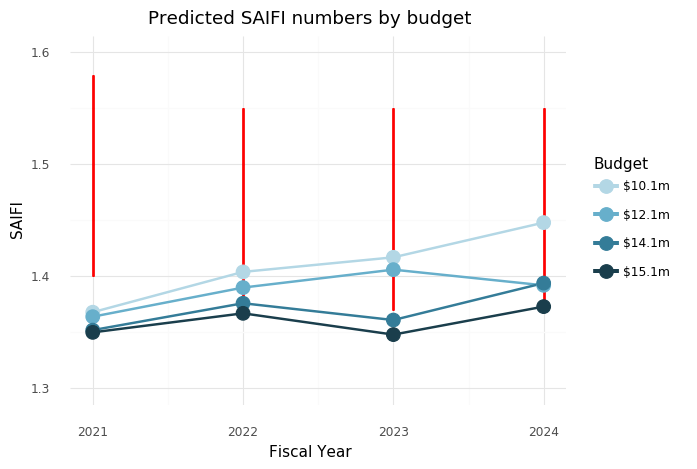

<ggplot: (-9223372036841286761)>


In [86]:
p1 = ggplot(full_long, aes(x='year', color='budget_strategy')) + \
    geom_segment(aes(x = 2021, y = 1.4, xend = 2021, yend = 1.58), color='red') + \
    geom_segment(aes(x = 2022, y = 1.37, xend = 2022, yend = 1.55), color='red') + \
    geom_segment(aes(x = 2023, y = 1.37, xend = 2023, yend = 1.55), color='red') + \
    geom_segment(aes(x = 2024, y = 1.37, xend = 2024, yend = 1.55), color='red') + \
    geom_line(aes(y='saifi'), size=1) + \
    geom_point(aes(y='saifi'), size=5) + \
    ylim(1.3, 1.6) + \
    scale_color_manual(values=["#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"]) + \
    xlab('Fiscal Year') + \
    ylab('SAIFI') + \
    labs(color='Budget') + \
    ggtitle('Predicted SAIFI numbers by budget') + \
    theme_minimal()

p1.save('SAIFI_predictions.png')

print(p1)
# Color codes for four budgets:
# "#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"

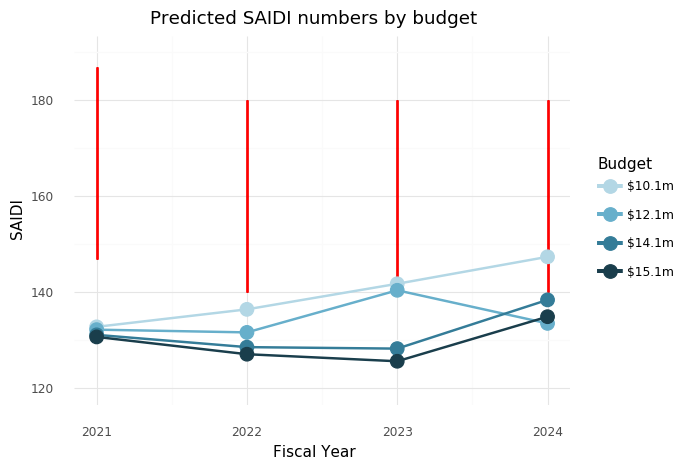

<ggplot: (-9223372036837740526)>


In [87]:
p2 = ggplot(full_long, aes(x='year', color='budget_strategy')) + \
    geom_segment(aes(x = 2021, y = 147, xend = 2021, yend = 187), color='red') + \
    geom_segment(aes(x = 2022, y = 140, xend = 2022, yend = 180), color='red') + \
    geom_segment(aes(x = 2023, y = 140, xend = 2023, yend = 180), color='red') + \
    geom_segment(aes(x = 2024, y = 140, xend = 2024, yend = 180), color='red') + \
    geom_line(aes(y='saidi'), size=1) + \
    geom_point(aes(y='saidi'), size=5) + \
    ylim(120, 190) + \
    scale_color_manual(values=["#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"]) + \
    xlab('Fiscal Year') + \
    ylab('SAIDI') + \
    labs(color='Budget') + \
    ggtitle('Predicted SAIDI numbers by budget') + \
    theme_minimal()

p2.save('SAIDI_predictions.png')

print(p2)
# Color codes for four budgets:
# "#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"

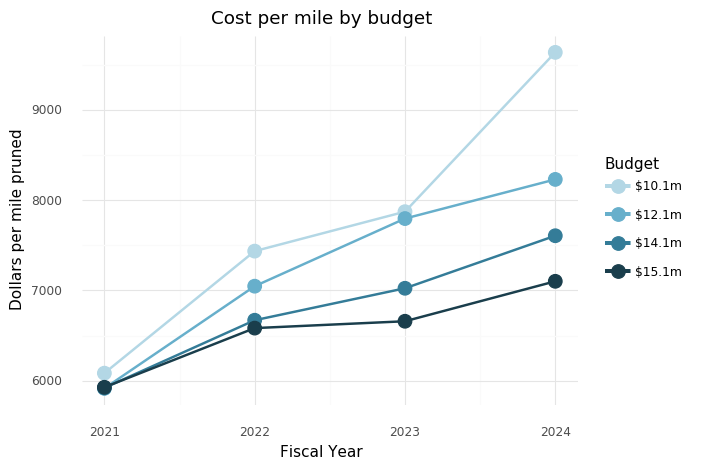

<ggplot: (17035405)>


In [88]:
p3 = ggplot(full_long, aes(x='year', y='cost_per_mi', color='budget_strategy')) + \
        geom_line(size=1) + \
        geom_point(size=5) + \
        scale_color_manual(values=["#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"]) + \
        xlab('Fiscal Year') + \
        ylab('Dollars per mile pruned') + \
        labs(color='Budget') + \
        ggtitle('Cost per mile by budget') + \
        theme_minimal()

p3.save('cost_per_mile_predictions.png')

print(p3)
# Color codes for four budgets:
# "#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"

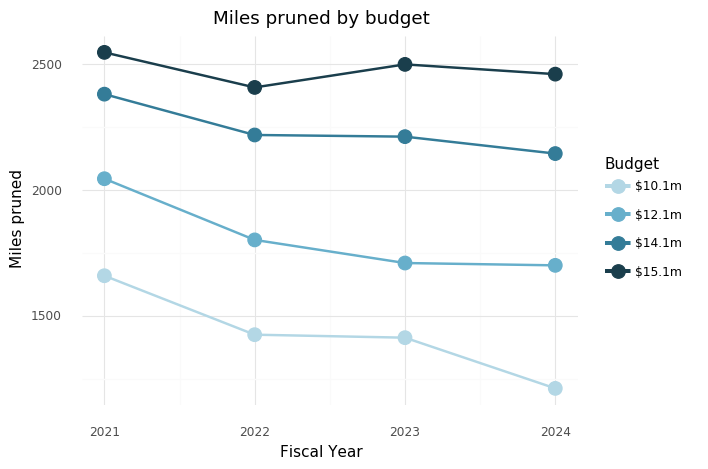

<ggplot: (-9223372036836296409)>


In [89]:
p4 = ggplot(full_long, aes(x='year', y='miles_pruned', color='budget_strategy')) + \
        geom_line(size=1) + \
        geom_point(size=5) + \
        scale_color_manual(values=["#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"]) + \
        xlab('Fiscal Year') + \
        ylab('Miles pruned') + \
        labs(color='Budget') + \
        ggtitle('Miles pruned by budget') + \
        theme_minimal()

p4.save('miles_pruned_predictions.png')

print(p4)
# Color codes for four budgets:
# "#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"

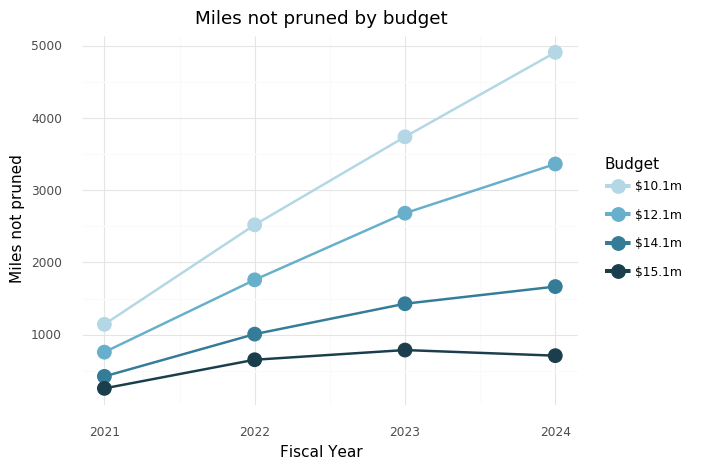

<ggplot: (-9223372036841301609)>


In [90]:
p5 = ggplot(full_long, aes(x='year', y='miles_not_pruned', color='budget_strategy')) + \
        geom_line(size=1) + \
        geom_point(size=5) + \
        scale_color_manual(values=["#b3d7e5", "#67afcb", "#347c98", "#1a3e4c"]) + \
        xlab('Fiscal Year') + \
        ylab('Miles not pruned') + \
        labs(color='Budget') + \
        ggtitle('Miles not pruned by budget') + \
        theme_minimal()

p5.save('miles_not_pruned_predictions_25.png')

print(p5)